Import Libraries

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


#**Problem Statement**
Using Example data, develop a model that predicts house prices based on the size of house.

# **Get Data**
We will use a truncated version of Ames dataset developed by Dean De Cock. 

In [3]:
from google.colab import files

uploaded = files.upload()

csv_housefile = next(iter(uploaded.keys()))

print('User uploaded file "{name}" with length {length} bytes'.format(name = csv_housefile, length = len (uploaded[csv_housefile])))

Saving AmesHousing-05-2010.csv to AmesHousing-05-2010.csv
User uploaded file "AmesHousing-05-2010.csv" with length 20140 bytes


# Load Data

In [4]:
import pandas as pd

df_housing = pd.read_csv(csv_housefile)

# Visualize the House Price Data

using pandas head method to look at the first few rows of data. This will give us an understanding of data we are working with

In [5]:
pd.set_option('display.max_columns', None)
df_housing.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639,Unf,0,441,1080,GasA,Fa,Y,SBrkr,1656,0,0,1656,1,0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,13,527166040,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,789,789,GasA,Gd,Y,SBrkr,789,676,0,1465,0,0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2,393,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,180400
2,38,528112020,20,RL,98.0,11478,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,Stone,200.0,Gd,TA,PConc,Ex,TA,No,GLQ,1218,Unf,0,486,1704,GasA,Ex,Y,SBrkr,1704,0,0,1704,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2008.0,RFn,3,772,TA,TA,Y,0,50,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,306000
3,56,528240070,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
4,59,528292020,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,180.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,884,884,GasA,Ex,Y,SBrkr,884,1151,0,2035,0,0,2,1,3,1,Gd,8,Typ,1,Gd,BuiltIn,2001.0,Fin,2,434,TA,TA,Y,144,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,222500


# Preparing the Data
There is no feature for the total space in the house which is sum of Basement and Upper Flooors. Lets add a new feature that contains this value called 'Total SF' to the dataset.

#Remove Missing values

In [6]:
df_housing[['Total Bsmt SF', 'Gr Liv Area']].isnull().values.any()

False

In [7]:
df_housing['Total SF'] = df_housing['Total Bsmt SF'] + df_housing['Gr Liv Area']

# Checking if the New Coloumn was made.

In [8]:
print(df_housing[['Total Bsmt SF', 'Gr Liv Area', 'Total SF', 'SalePrice']].head(5))

   Total Bsmt SF  Gr Liv Area  Total SF  SalePrice
0           1080         1656      2736     215000
1            789         1465      2254     180400
2           1704         1704      3408     306000
3            860         1960      2820     216500
4            884         2035      2919     222500


# Visualize the data
To understand the relationship between the various features.

In [9]:
def visualize_data(x_vals, y_vals, addn_x_vals = None, addn_y_vals = None, add_addn_reg_line = False):
  f, ax = plt.subplots(figsize = (8,8))
  plt.plot(x_vals, y_vals, 'ro')
  if(addn_x_vals is not None):
    plt.plot(addn_x_vals, addn_y_vals, 'g^')
    if(add_addn_reg_line):
      x_min_index = addn_x_vals.argmin()
      x_max_index = addn_x_vals.argmax()
      print(x_min_index, [addn_x_vals[x_min_index],addn_y_vals[x_min_index]] )
      print(x_max_index, [addn_x_vals[x_max_index],addn_y_vals[x_max_index]] )
      plt.plot( [addn_x_vals[x_min_index] , addn_y_vals[x_min_index] ] ,
      [addn_x_vals[x_max_index] , addn_y_vals[x_max_index]],
      'b-')

      plt.tick_params(axis="both", which="major", labelsize=14)

      plt.show()

# draw a blue regression line

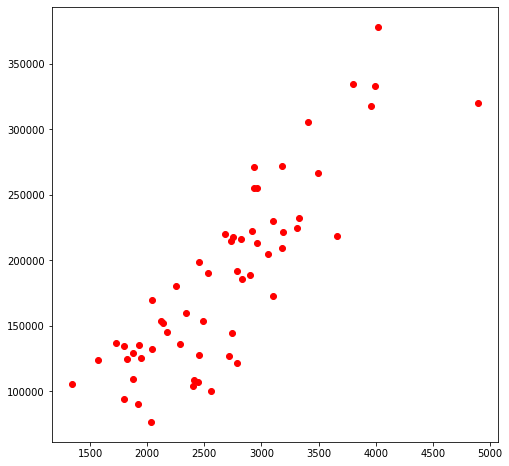

In [16]:
visualize_data(df_housing['Total SF'], df_housing['SalePrice'])

# Scale X and Y axis to a common Scale
using scikit-learn preprocessing package to scale the data on both axes.

In [15]:
from sklearn.preprocessing import MinMaxScaler

sf_scaler = MinMaxScaler()
sf_scaled = sf_scaler.fit_transform(df_housing['Total SF'].values.reshape(-1,1).astype(np.float64))

price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df_housing['SalePrice'].values.reshape(-1,1).astype(np.float64))

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(1,), kernel_initializer='zeros'))
